# Power calculation for snRNA-seq based QTL studies

Here I perform power and sample size calculations for eQTL in snRNA-seq using the pseudo-bulk approach, ie, average gene expression of per cell type.

## Motivation

What we are interested in is how sample size $N$, number of cells per sample $M$, and cell proportions $P$ impact the power of pseudo-bulk RNA-seq expression.

What we will not evaluate are:

- Variance QTL: it is not our priority to study "noise genetics" and even so, we may need [thousands of samples to detect an effect](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1008045).
- [Non-Gaussian model for single-cell eQTL](https://www.biorxiv.org/content/10.1101/2022.08.14.503915v1.full.pdf), because we know the ground truth and we evaluate it per cell type. Calculations here represent an optimal estimate of power, ie, an underestimate in the real world snRNA/scRNA data.

## Approach

1. Simulate genotype data for one variant across $N$ individuals, $x_i, \ldots, x_N$ are genotypic value of a variant sampled for $N$ individuals from $Binom(2, 0.1)$ (assuming MAF = 10%), then standardized to have mean zero and unit variance.

2. Simulation of gene expressions of a cell for from generative model $y_{ic} = x_ib + e$ where $y_{ic}$ is the expression value of a cell $c$ in individual $i$, $y_{ic} \sim N(0,1)$, $b$ is effect size of eQTL, $b \sim N(0, \sigma^2)$ where $\sigma^2$ is effect size that reflects heritability of $x$, eg, $\sigma^2 = 5\%$ means that the variant $x$ explains 5% variation for the expression. Finally, $e \sim N(0, 1-\sigma^2)$.

3. Determine how many cells are observed from an individual for cell type $c$, via sampling from a binomial distribution $M_c \sim Binom(M, P_c)$ where $M$ is the total number of cells measured per individual and $P_c$ is the proportion of cell type $c$.

4. Compute pseudo-bulk mean expression values of an individual as $y_i = \sum_c^{M_c} y_{ic} / M_c$ where $M_c$ is the total number of cells for cell type $c$ in an individual sampled. 

5. Repeat 2 ~ 4 on $N$ individuals to get the expression value $y$ which is a length $N$ vector of expression values; then fit a regression model `lm(y~x)` and get the p-value from it.

6. Repeat 1 ~ 5 for 1,000 times. A p-value cutoff of $5 \times 10^{-5}$ will be used as the significant threshold, assuming there are 1,000 independent genetic variants evaluated for eQTLs in the cis-region of a gene. 

## Implemenetation

Simulate genotype data,

In [2]:
get_genotypes = function(N, MAF) {
    x = rbinom(10, 2, 0.1)
    return (scale(x, center=T))
}

Simulate per cell effect from generative model, for $M_c \sim Binom(M, P_c)$ cells, then take the average to get the phenotype for each individual,

In [3]:
get_cell_count_individual = function(M, p) {
    return (rbinom(1, M, p))
}

get_phenotype = function(x, C, sigma2) {
    # genetic effect, fixed for all cells and all individuals as our association testing model assumes
    b = rnorm(1, 0, sqrt(sigma2))
    # 
    e = rnorm(C, 0, sqrt(1-sigma2))
    return (mean(xi * b + e))
}

## Use existing tools

I should have searched for it in the first place ... here are tools to perform the calculation

- https://www.nature.com/articles/s41467-021-26779-7
- https://bwhbioinfo.shinyapps.io/powerEQTL/

I will use the 2nd approach which is close to what I did above.

In [3]:
pve = 0.05
b = sqrt(pve)

# sample size
N = c(200,350,650,800,1000,1500)
nn <- length(N)
# MAF
MAF <- seq(0.5,40,0.1)/100
nq <- length(MAF)

# number of independent SNPs tested
nSNP = 500

# inter-cell correlation
rho = 0.2

# significant level (FP)
a=0.05

# total cells per sample and prop of cell type
M = 40000
p = 0.002

# obtain power for linear mixed model
power_lmm <- array(numeric(nn*nq), dim=c(nn,nq))
for (i in 1:nn){
    for (j in 1:nq){
        result <- powerEQTL::powerEQTL.scRNAseq(slope=b, n=N[i], m=M*p, sigma.y=1, MAF=MAF[j], power=NULL, rho=rho, FWER=a, nTests=nSNP)
        power_lmm[i,j] <-result;
    }
}

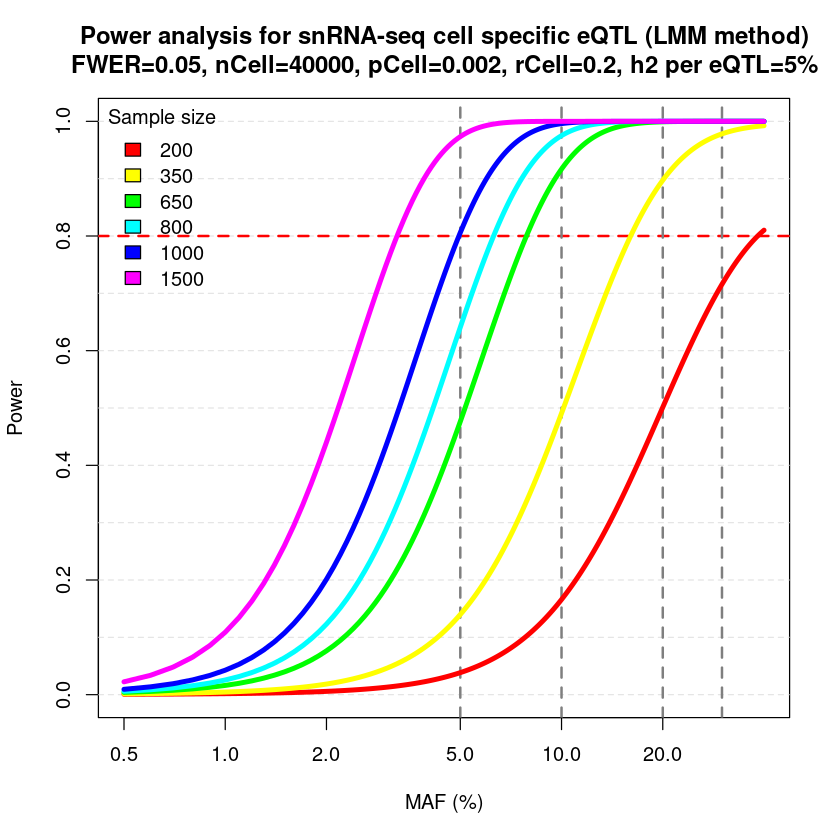

In [4]:
# set up graph
xrange <- range(MAF*100)
yrange <- c(0:1)
colors <- rainbow(length(N))
plot(xrange, yrange, log='x', type="n",
     xlab="MAF (%)",
     ylab="Power",
     main=paste0("Power analysis for snRNA-seq cell specific eQTL (LMM method)\nFWER=", a, ", nCell=", M, ", pCell=", p, ", rCell=", rho, ", h2 per eQTL=", pve*100,"%")
     )

abline(v=0, h=seq(0,1,.1), lty=2, col="grey89")
abline(v=0, h=0.8, lty=2, lwd=2, col="red")
abline(v=c(5, 10, 20, 30), lty=2, lwd=2, col="grey50")
#abline(v=c(3, 5, 10), lty=2, lwd=2, col="grey50")

# add power curves
for (i in 1:nn){
    lines(MAF*100, power_lmm[i,], type="l", lwd=4, col=colors[i])
}

legend("topleft", title="Sample size", as.character(N),fill=colors, bty='n')

In [2]:
# obtain power for ZINB model
power_zinb <- array(numeric(nn*nq), dim=c(nn,nq))
for (i in 1:nn){
    for (j in 1:nq){
        result <- powerEQTL::powerEQTL.scRNAseq.sim(slope=b, 
                            n=N[i],
                            m=M*p, 
                            power = NULL,
                            m.int = -1, 
                            sigma.int = 1, 
                            zero.p = 0.1,
                            theta = 1,
                            MAF =MAF[j], 
                            FWER = a, 
                            nTests = nSNP, 
                            nSim = 1000, 
                            estMethod = "GLMMadaptive", 
                            nCores = 10,
                            n.lower = 2.01,
                            n.upper = 1e+4,
                            slope.lower =  1e-6,
                            slope.upper = log(1.0e+6),
                            MAF.lower = 0.05,
                            MAF.upper = 0.49)
        power_zinb[i,j] <-result;
    }
}